## ISID Project - Stock Trading using Reinforcement Learning

### Importing the libraries

In [1]:
# !pip install tensorflow==1.15
# !pip install keras==2.1.6

In [2]:
import pandas as pd
import numpy as np
import yfinance as yf

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
from stable_baselines.common.policies import MlpPolicy
from stable_baselines.common.vec_env import DummyVecEnv
from stable_baselines import PPO2, A2C

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [5]:
import tensorflow as tf

In [46]:
from env import StockTradingEnv
from agent import DDPG

### Importing the dataset

In [7]:
data = yf.download('GOOGL', period = 'max')

[*********************100%***********************]  1 of 1 completed


In [8]:
data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2004-08-19,50.050049,52.082081,48.028027,50.220219,50.220219,44659000
2004-08-20,50.555557,54.594593,50.300301,54.209209,54.209209,22834300
2004-08-23,55.430431,56.796795,54.579578,54.754753,54.754753,18256100
2004-08-24,55.675674,55.855854,51.836838,52.487488,52.487488,15247300
2004-08-25,52.532532,54.054054,51.991993,53.053055,53.053055,9188600
...,...,...,...,...,...,...
2019-12-27,1364.000000,1367.050049,1353.000000,1354.640015,1354.640015,1160600
2019-12-30,1356.810059,1357.000000,1337.839966,1339.709961,1339.709961,999700
2019-12-31,1335.790039,1340.660034,1332.130005,1339.390015,1339.390015,975700


In [9]:
data['Date'] = data.index
data.index = np.arange(0, len(data))

In [10]:
data

,Open,High,Low,Close,Adj Close,Volume,Date
0,50.050049,52.082081,48.028027,50.220219,50.220219,44659000,2004-08-19
1,50.555557,54.594593,50.300301,54.209209,54.209209,22834300,2004-08-20
2,55.430431,56.796795,54.579578,54.754753,54.754753,18256100,2004-08-23
3,55.675674,55.855854,51.836838,52.487488,52.487488,15247300,2004-08-24
4,52.532532,54.054054,51.991993,53.053055,53.053055,9188600,2004-08-25
...,...,...,...,...,...,...,...
3866,1364.000000,1367.050049,1353.000000,1354.640015,1354.640015,1160600,2019-12-27
3867,1356.810059,1357.000000,1337.839966,1339.709961,1339.709961,999700,2019-12-30
3868,1335.790039,1340.660034,1332.130005,1339.390015,1339.390015,975700,2019-12-31
3869,1348.410034,1368.680054,1346.489990,1368.680054,1368.680054,1363900,2020-01-02


In [11]:
data_train = yf.download('GOOGL', start = '2010-01-01', end = '2018-01-01')
data_test = yf.download('GOOGL', period = '2y', interval = '1h')

data_train['Date'] = data_train.index
data_test['Date'] = data_test.index

data_train.index = np.arange(0, len(data_train))
data_test.index = np.arange(0, len(data_test))

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [12]:
data_train

,Open,High,Low,Close,Adj Close,Volume,Date
0,312.687683,313.013000,310.300293,310.300293,310.300293,2437100,2009-12-31
1,313.788788,315.070068,312.432434,313.688690,313.688690,3908400,2010-01-04
2,313.903900,314.234222,311.081085,312.307312,312.307312,6003300,2010-01-05
3,313.243256,313.243256,303.483490,304.434448,304.434448,7949400,2010-01-06
4,305.005005,305.305298,296.621613,297.347351,297.347351,12815700,2010-01-07
...,...,...,...,...,...,...,...
2009,1070.000000,1071.719971,1067.640015,1068.859985,1068.859985,889400,2017-12-22
2010,1068.640015,1068.859985,1058.640015,1065.849976,1065.849976,918800,2017-12-26
2011,1066.599976,1068.270020,1058.380005,1060.199951,1060.199951,1116200,2017-12-27
2012,1062.250000,1064.839966,1053.380005,1055.949951,1055.949951,994200,2017-12-28


### Data Visualization

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


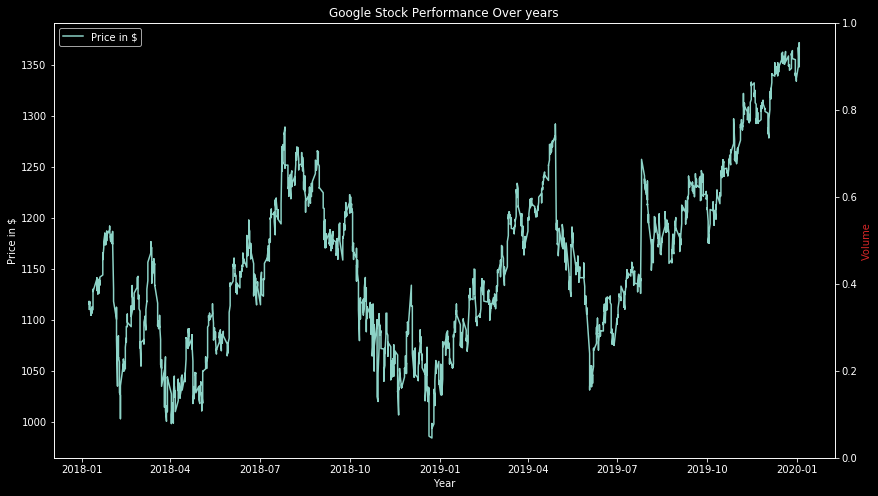

In [13]:
def plot_stock(data):
  plt.rcParams['figure.figsize'] = [14, 8]

  x1 = np.array(data['Date'])
  y1 = data['Open']
  y12 = data['Volume']

  plt.title("Google Stock Performance Over years")
  plt.xlabel("Year")
  plt.ylabel("Price in $")

  price = plt.plot(x1,y1, label = "Price in $")

  ax2 = plt.twinx()  # instantiate a second axes that shares the same x-axis

  color = 'tab:red'
  ax2.set_ylabel('Volume', color=color)  # we already handled the x-label with ax1
  # volume = ax2.plot(x1, y12, color=color, label = "Volume")
  
  # ax2.tick_params(axis='y', labelcolor=color)

  # plots = price + volume
  plots = price
  labels = [plot.get_label() for plot in plots]
  plt.legend(plots, labels, loc="upper left")

  plt.show()

plot_stock(data_test)

### Trying different predefined RL Agents on Google, Apple, Microsoft and Amazon Stock Data

Calculating average profits from 2018 to present on 10 different tries

In [26]:
profits = {}
stocks = ['AAPL', 'GOOGL', 'MSFT', 'AMZN']
TIMESTEPS = 20000

#### A2C Model

In [28]:
a2c_profits = {}
for stock in stocks:
    
    data_train = yf.download(stock, start = '2010-01-01', end = '2018-01-01')
    data_test = yf.download(stock, period = '2y', interval = '1h')

    data_train['Date'] = data_train.index
    data_test['Date'] = data_test.index

    data_train.index = np.arange(0, len(data_train))
    data_test.index = np.arange(0, len(data_test))
    
    env = DummyVecEnv([lambda: StockTradingEnv(data_train)])

    model = A2C(MlpPolicy, env, verbose=1)
    model.learn(total_timesteps=TIMESTEPS)

    model_profits = []

    for _ in range(10):
        env_test = StockTradingEnv(data_test)
        env_test.reset()
        env.envs[0] = env_test
        obs = env.reset()

        for i in range(len(data_test)):
            action, _states = model.predict(obs)
            obs, rewards, done, info = env.step(action)
            env.render(mode='no')
        print(env.envs[0].profit)
        model_profits.append(env.envs[0].profit)
    a2c_profits[stock] = np.mean(model_profits)

profits['A2C'] = a2c_profits

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


/Users/mac/Desktop/Projects/StockTradingRL/env.py:102: RuntimeWarning: invalid value encountered in double_scalars
  prev_cost + additional_cost) / (self.shares_held + shares_bought)


----------------------------------
| explained_variance | -0.000228 |
| fps                | 13        |
| nupdates           | 1         |
| policy_entropy     | 2.84      |
| total_timesteps    | 5         |
| value_loss         | 145       |
----------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 231      |
| nupdates           | 100      |
| policy_entropy     | 2.84     |
| total_timesteps    | 500      |
| value_loss         | 2.65e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 246      |
| nupdates           | 200      |
| policy_entropy     | 2.83     |
| total_timesteps    | 1000     |
| value_loss         | 1.07e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 254      |
| nupdates           | 300      |
| policy_entropy     | 2.82     |
| tota

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 254       |
| nupdates           | 3000      |
| policy_entropy     | 2.68      |
| total_timesteps    | 15000     |
| value_loss         | 1.12e+07  |
----------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 255       |
| nupdates           | 3100      |
| policy_entropy     | 2.67      |
| total_timesteps    | 15500     |
| value_loss         | 2.1e+07   |
----------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 256      |
| nupdates           | 3200     |
| policy_entropy     | 2.68     |
| total_timesteps    | 16000    |
| value_loss         | 4.04e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 258      |
| nupdates           | 3300     |
| policy_entropy     | 2.67     

/Users/mac/Desktop/Projects/StockTradingRL/env.py:102: RuntimeWarning: invalid value encountered in double_scalars
  prev_cost + additional_cost) / (self.shares_held + shares_bought)


---------------------------------
| explained_variance | 0.000656 |
| fps                | 15       |
| nupdates           | 1        |
| policy_entropy     | 2.84     |
| total_timesteps    | 5        |
| value_loss         | 274      |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 281       |
| nupdates           | 100       |
| policy_entropy     | 2.83      |
| total_timesteps    | 500       |
| value_loss         | 2.69e+06  |
----------------------------------
----------------------------------
| explained_variance | -3.58e-07 |
| fps                | 309       |
| nupdates           | 200       |
| policy_entropy     | 2.82      |
| total_timesteps    | 1000      |
| value_loss         | 1.06e+07  |
----------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 317      |
| nupdates           | 300      |
| policy_entropy     | 2.82     

---------------------------------
| explained_variance | 0        |
| fps                | 318      |
| nupdates           | 3000     |
| policy_entropy     | 2.63     |
| total_timesteps    | 15000    |
| value_loss         | 1.05e+07 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 319      |
| nupdates           | 3100     |
| policy_entropy     | 2.63     |
| total_timesteps    | 15500    |
| value_loss         | 2.1e+07  |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 319      |
| nupdates           | 3200     |
| policy_entropy     | 2.61     |
| total_timesteps    | 16000    |
| value_loss         | 1.21e+08 |
---------------------------------
----------------------------------
| explained_variance | -8.34e-07 |
| fps                | 319       |
| nupdates           | 3300      |
| policy_entropy     | 2.61      |
| total_t

/Users/mac/Desktop/Projects/StockTradingRL/env.py:102: RuntimeWarning: invalid value encountered in double_scalars
  prev_cost + additional_cost) / (self.shares_held + shares_bought)


---------------------------------
| explained_variance | 6.97e-05 |
| fps                | 14       |
| nupdates           | 1        |
| policy_entropy     | 2.84     |
| total_timesteps    | 5        |
| value_loss         | 230      |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 280      |
| nupdates           | 100      |
| policy_entropy     | 2.83     |
| total_timesteps    | 500      |
| value_loss         | 2.65e+06 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 305      |
| nupdates           | 200      |
| policy_entropy     | 2.83     |
| total_timesteps    | 1000     |
| value_loss         | 1.06e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 317      |
| nupdates           | 300      |
| policy_entropy     | 2.83     |
| total_timest

---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 327      |
| nupdates           | 3000     |
| policy_entropy     | 2.69     |
| total_timesteps    | 15000    |
| value_loss         | 1.02e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 326      |
| nupdates           | 3100     |
| policy_entropy     | 2.68     |
| total_timesteps    | 15500    |
| value_loss         | 2.1e+07  |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 324       |
| nupdates           | 3200      |
| policy_entropy     | 2.67      |
| total_timesteps    | 16000     |
| value_loss         | 3.93e+07  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 322      |
| nupdates           | 3300     |
| policy_entropy     | 2.67     |
| tota

/Users/mac/Desktop/Projects/StockTradingRL/env.py:102: RuntimeWarning: invalid value encountered in double_scalars
  prev_cost + additional_cost) / (self.shares_held + shares_bought)


---------------------------------
| explained_variance | 0.000293 |
| fps                | 15       |
| nupdates           | 1        |
| policy_entropy     | 2.84     |
| total_timesteps    | 5        |
| value_loss         | 267      |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 284      |
| nupdates           | 100      |
| policy_entropy     | 2.83     |
| total_timesteps    | 500      |
| value_loss         | 2.73e+06 |
---------------------------------
---------------------------------
| explained_variance | 1.73e-06 |
| fps                | 310      |
| nupdates           | 200      |
| policy_entropy     | 2.82     |
| total_timesteps    | 1000     |
| value_loss         | 1.09e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 319      |
| nupdates           | 300      |
| policy_entropy     | 2.82     |
| total_timest

---------------------------------
| explained_variance | 8.34e-07 |
| fps                | 313      |
| nupdates           | 3000     |
| policy_entropy     | 2.68     |
| total_timesteps    | 15000    |
| value_loss         | 1.85e+07 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 312       |
| nupdates           | 3100      |
| policy_entropy     | 2.67      |
| total_timesteps    | 15500     |
| value_loss         | 2.09e+07  |
----------------------------------
---------------------------------
| explained_variance | 2.38e-07 |
| fps                | 312      |
| nupdates           | 3200     |
| policy_entropy     | 2.66     |
| total_timesteps    | 16000    |
| value_loss         | 3.47e+08 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 313      |
| nupdates           | 3300     |
| policy_entropy     | 2.68     |
| tota

#### PPO2 Model

In [29]:
ppo_profits = {}
for stock in stocks:
    
    data_train = yf.download(stock, start = '2010-01-01', end = '2018-01-01')
    data_test = yf.download(stock, period = '2y', interval = '1h')

    data_train['Date'] = data_train.index
    data_test['Date'] = data_test.index

    data_train.index = np.arange(0, len(data_train))
    data_test.index = np.arange(0, len(data_test))
    
    env = DummyVecEnv([lambda: StockTradingEnv(data_train)])

    model = PPO2(MlpPolicy, env, verbose=1)
    model.learn(total_timesteps=TIMESTEPS)

    model_profits = []

    for _ in range(10):
        env_test = StockTradingEnv(data_test)
        env_test.reset()
        env.envs[0] = env_test
        obs = env.reset()

        for i in range(len(data_test)):
            action, _states = model.predict(obs)
            obs, rewards, done, info = env.step(action)
            env.render(mode='no')
        print(env.envs[0].profit)
        model_profits.append(env.envs[0].profit)
    ppo_profits[stock] = np.mean(model_profits)

profits['PPO'] = ppo_profits

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
--------------------------------------
| approxkl           | 4.126248e-08  |
| clipfrac           | 0.0           |
| explained_variance | -2.38e-07     |
| fps                | 174           |
| n_updates          | 1             |
| policy_entropy     | 2.8378663     |
| policy_loss        | 1.1373777e-06 |
| serial_timesteps   | 128           |
| time_elapsed       | 3.1e-06       |
| total_timesteps    | 128           |
| value_loss         | 676422.3      |
--------------------------------------
---------------------------------------
| approxkl           | 9.621919e-08   |
| clipfrac           | 0.0            |
| explained_variance | 0              |
| fps                | 345            |
| n_updates          | 2              |
| policy_entropy     | 2.8383455      |
| policy_loss        | -4.2046304e-05 |
| serial_timesteps   | 256         

--------------------------------------
| approxkl           | 3.4247544e-06 |
| clipfrac           | 0.0           |
| explained_variance | 8.29e-06      |
| fps                | 331           |
| n_updates          | 17            |
| policy_entropy     | 2.8430443     |
| policy_loss        | 0.00012210797 |
| serial_timesteps   | 2176          |
| time_elapsed       | 6.56          |
| total_timesteps    | 2176          |
| value_loss         | 1585740.0     |
--------------------------------------
---------------------------------------
| approxkl           | 3.8084868e-06  |
| clipfrac           | 0.0            |
| explained_variance | -4.65e-06      |
| fps                | 352            |
| n_updates          | 18             |
| policy_entropy     | 2.841549       |
| policy_loss        | -0.00017265195 |
| serial_timesteps   | 2304           |
| time_elapsed       | 6.94           |
| total_timesteps    | 2304           |
| value_loss         | 6870292.0      |
-------------

---------------------------------------
| approxkl           | 3.3834564e-05  |
| clipfrac           | 0.0            |
| explained_variance | -4.53e-06      |
| fps                | 344            |
| n_updates          | 34             |
| policy_entropy     | 2.8760335      |
| policy_loss        | -0.00076086354 |
| serial_timesteps   | 4352           |
| time_elapsed       | 13.6           |
| total_timesteps    | 4352           |
| value_loss         | 11425481.0     |
---------------------------------------
---------------------------------------
| approxkl           | 0.00019461772  |
| clipfrac           | 0.0            |
| explained_variance | -5.48e-06      |
| fps                | 312            |
| n_updates          | 35             |
| policy_entropy     | 2.880046       |
| policy_loss        | -0.00093295635 |
| serial_timesteps   | 4480           |
| time_elapsed       | 14             |
| total_timesteps    | 4480           |
| value_loss         | 20521640.0     |


-------------------------------------
| approxkl           | 0.0009899326 |
| clipfrac           | 0.0          |
| explained_variance | -1.07e-06    |
| fps                | 364          |
| n_updates          | 51           |
| policy_entropy     | 2.8919978    |
| policy_loss        | 0.0022407775 |
| serial_timesteps   | 6528         |
| time_elapsed       | 24           |
| total_timesteps    | 6528         |
| value_loss         | 37876964.0   |
-------------------------------------
-------------------------------------
| approxkl           | 0.0009907621 |
| clipfrac           | 0.00390625   |
| explained_variance | 0            |
| fps                | 338          |
| n_updates          | 52           |
| policy_entropy     | 2.8913057    |
| policy_loss        | 0.0024827356 |
| serial_timesteps   | 6656         |
| time_elapsed       | 24.3         |
| total_timesteps    | 6656         |
| value_loss         | 67558940.0   |
-------------------------------------
------------

-------------------------------------
| approxkl           | 0.0012099149 |
| clipfrac           | 0.0          |
| explained_variance | 2.98e-07     |
| fps                | 175          |
| n_updates          | 68           |
| policy_entropy     | 2.8866227    |
| policy_loss        | 0.0011899406 |
| serial_timesteps   | 8704         |
| time_elapsed       | 33.9         |
| total_timesteps    | 8704         |
| value_loss         | 99186616.0   |
-------------------------------------
--------------------------------------
| approxkl           | 0.00017327763 |
| clipfrac           | 0.0           |
| explained_variance | 2.03e-06      |
| fps                | 188           |
| n_updates          | 69            |
| policy_entropy     | 2.8871825     |
| policy_loss        | 0.00031471427 |
| serial_timesteps   | 8832          |
| time_elapsed       | 34.6          |
| total_timesteps    | 8832          |
| value_loss         | 201034740.0   |
--------------------------------------

--------------------------------------
| approxkl           | 0.00058581855 |
| clipfrac           | 0.0           |
| explained_variance | 2.38e-06      |
| fps                | 184           |
| n_updates          | 85            |
| policy_entropy     | 2.8932965     |
| policy_loss        | 0.0017894198  |
| serial_timesteps   | 10880         |
| time_elapsed       | 45.7          |
| total_timesteps    | 10880         |
| value_loss         | 150388640.0   |
--------------------------------------
-------------------------------------
| approxkl           | 0.0002494763 |
| clipfrac           | 0.0          |
| explained_variance | -3.58e-07    |
| fps                | 194          |
| n_updates          | 86           |
| policy_entropy     | 2.8940177    |
| policy_loss        | 0.001595972  |
| serial_timesteps   | 11008        |
| time_elapsed       | 46.4         |
| total_timesteps    | 11008        |
| value_loss         | 172964270.0  |
-------------------------------------

--------------------------------------
| approxkl           | 0.00032396716 |
| clipfrac           | 0.0           |
| explained_variance | -1.07e-06     |
| fps                | 335           |
| n_updates          | 102           |
| policy_entropy     | 2.8995378     |
| policy_loss        | 0.0030369796  |
| serial_timesteps   | 13056         |
| time_elapsed       | 56.7          |
| total_timesteps    | 13056         |
| value_loss         | 235124530.0   |
--------------------------------------
--------------------------------------
| approxkl           | 0.00028534143 |
| clipfrac           | 0.0           |
| explained_variance | 2.38e-07      |
| fps                | 230           |
| n_updates          | 103           |
| policy_entropy     | 2.8989043     |
| policy_loss        | -0.0004896319 |
| serial_timesteps   | 13184         |
| time_elapsed       | 57.1          |
| total_timesteps    | 13184         |
| value_loss         | 354846600.0   |
-------------------------

---------------------------------------
| approxkl           | 0.00023736345  |
| clipfrac           | 0.0            |
| explained_variance | -2.38e-07      |
| fps                | 294            |
| n_updates          | 119            |
| policy_entropy     | 2.9017413      |
| policy_loss        | -0.00018618861 |
| serial_timesteps   | 15232          |
| time_elapsed       | 66.7           |
| total_timesteps    | 15232          |
| value_loss         | 314044580.0    |
---------------------------------------
-------------------------------------
| approxkl           | 0.0006001997 |
| clipfrac           | 0.0          |
| explained_variance | -1.31e-06    |
| fps                | 202          |
| n_updates          | 120          |
| policy_entropy     | 2.9019997    |
| policy_loss        | 0.005230886  |
| serial_timesteps   | 15360        |
| time_elapsed       | 67.1         |
| total_timesteps    | 15360        |
| value_loss         | 305507200.0  |
------------------------

--------------------------------------
| approxkl           | 0.0025569815  |
| clipfrac           | 0.01171875    |
| explained_variance | 0             |
| fps                | 341           |
| n_updates          | 136           |
| policy_entropy     | 2.9063227     |
| policy_loss        | 0.00034074008 |
| serial_timesteps   | 17408         |
| time_elapsed       | 75.4          |
| total_timesteps    | 17408         |
| value_loss         | 519239520.0   |
--------------------------------------
-------------------------------------
| approxkl           | 0.0008759028 |
| clipfrac           | 0.0          |
| explained_variance | 2.98e-07     |
| fps                | 358          |
| n_updates          | 137          |
| policy_entropy     | 2.905771     |
| policy_loss        | 0.002845258  |
| serial_timesteps   | 17536        |
| time_elapsed       | 75.8         |
| total_timesteps    | 17536        |
| value_loss         | 584021900.0  |
-------------------------------------

-------------------------------------
| approxkl           | 6.249545e-05 |
| clipfrac           | 0.0          |
| explained_variance | 1.79e-07     |
| fps                | 372          |
| n_updates          | 153          |
| policy_entropy     | 2.9086945    |
| policy_loss        | 0.0017129254 |
| serial_timesteps   | 19584        |
| time_elapsed       | 82.1         |
| total_timesteps    | 19584        |
| value_loss         | 515701220.0  |
-------------------------------------
-------------------------------------
| approxkl           | 0.0010131823 |
| clipfrac           | 0.0          |
| explained_variance | -2.38e-07    |
| fps                | 355          |
| n_updates          | 154          |
| policy_entropy     | 2.9077678    |
| policy_loss        | -0.002983728 |
| serial_timesteps   | 19712        |
| time_elapsed       | 82.5         |
| total_timesteps    | 19712        |
| value_loss         | 593675460.0  |
-------------------------------------
------------

--------------------------------------
| approxkl           | 3.9438146e-06 |
| clipfrac           | 0.0           |
| explained_variance | -3.1e-06      |
| fps                | 208           |
| n_updates          | 13            |
| policy_entropy     | 2.8501472     |
| policy_loss        | -0.0003594705 |
| serial_timesteps   | 1664          |
| time_elapsed       | 9.78          |
| total_timesteps    | 1664          |
| value_loss         | 353985000.0   |
--------------------------------------
---------------------------------------
| approxkl           | 3.4453067e-05  |
| clipfrac           | 0.0            |
| explained_variance | -5.84e-06      |
| fps                | 293            |
| n_updates          | 14             |
| policy_entropy     | 2.8502624      |
| policy_loss        | -0.00032009662 |
| serial_timesteps   | 1792           |
| time_elapsed       | 10.4           |
| total_timesteps    | 1792           |
| value_loss         | 448523300.0    |
-------------

--------------------------------------
| approxkl           | 0.00015635166 |
| clipfrac           | 0.0           |
| explained_variance | -1.29e-05     |
| fps                | 110           |
| n_updates          | 30            |
| policy_entropy     | 2.8801253     |
| policy_loss        | -0.001710776  |
| serial_timesteps   | 3840          |
| time_elapsed       | 33.9          |
| total_timesteps    | 3840          |
| value_loss         | 620448400.0   |
--------------------------------------
-------------------------------------
| approxkl           | 0.000561582  |
| clipfrac           | 0.0          |
| explained_variance | -5.36e-06    |
| fps                | 104          |
| n_updates          | 31           |
| policy_entropy     | 2.8799696    |
| policy_loss        | 0.0007952396 |
| serial_timesteps   | 3968         |
| time_elapsed       | 35.1         |
| total_timesteps    | 3968         |
| value_loss         | 1127423200.0 |
-------------------------------------

--------------------------------------
| approxkl           | 0.0010573607  |
| clipfrac           | 0.00390625    |
| explained_variance | -8.46e-06     |
| fps                | 37            |
| n_updates          | 47            |
| policy_entropy     | 2.894469      |
| policy_loss        | -0.0012949981 |
| serial_timesteps   | 6016          |
| time_elapsed       | 71.5          |
| total_timesteps    | 6016          |
| value_loss         | 654056900.0   |
--------------------------------------
--------------------------------------
| approxkl           | 9.5993026e-05 |
| clipfrac           | 0.0           |
| explained_variance | 9.45e-05      |
| fps                | 27            |
| n_updates          | 48            |
| policy_entropy     | 2.8956141     |
| policy_loss        | 0.0022040773  |
| serial_timesteps   | 6144          |
| time_elapsed       | 75            |
| total_timesteps    | 6144          |
| value_loss         | 71305470.0    |
-------------------------

--------------------------------------
| approxkl           | 3.879299e-05  |
| clipfrac           | 0.0           |
| explained_variance | -8.86e-05     |
| fps                | 21            |
| n_updates          | 64            |
| policy_entropy     | 2.9066236     |
| policy_loss        | 0.00076872855 |
| serial_timesteps   | 8192          |
| time_elapsed       | 160           |
| total_timesteps    | 8192          |
| value_loss         | 994382.25     |
--------------------------------------
-------------------------------------
| approxkl           | 6.339136e-05 |
| clipfrac           | 0.0          |
| explained_variance | -7.03e-06    |
| fps                | 9            |
| n_updates          | 65           |
| policy_entropy     | 2.90617      |
| policy_loss        | 0.0020986397 |
| serial_timesteps   | 8320         |
| time_elapsed       | 166          |
| total_timesteps    | 8320         |
| value_loss         | 7205910.0    |
-------------------------------------

--------------------------------------
| approxkl           | 0.00037192422 |
| clipfrac           | 0.0           |
| explained_variance | -7.39e-06     |
| fps                | 9             |
| n_updates          | 81            |
| policy_entropy     | 2.9135122     |
| policy_loss        | 0.00063167093 |
| serial_timesteps   | 10368         |
| time_elapsed       | 266           |
| total_timesteps    | 10368         |
| value_loss         | 10326644.0    |
--------------------------------------
-------------------------------------
| approxkl           | 0.0003182409 |
| clipfrac           | 0.0          |
| explained_variance | 4.17e-07     |
| fps                | 8            |
| n_updates          | 82           |
| policy_entropy     | 2.9138453    |
| policy_loss        | -0.002249283 |
| serial_timesteps   | 10496        |
| time_elapsed       | 281          |
| total_timesteps    | 10496        |
| value_loss         | 24047698.0   |
-------------------------------------

--------------------------------------
| approxkl           | 0.0007786595  |
| clipfrac           | 0.0           |
| explained_variance | -1.25e-05     |
| fps                | 82            |
| n_updates          | 98            |
| policy_entropy     | 2.91776       |
| policy_loss        | -0.0005402055 |
| serial_timesteps   | 12544         |
| time_elapsed       | 365           |
| total_timesteps    | 12544         |
| value_loss         | 24236132.0    |
--------------------------------------
-------------------------------------
| approxkl           | 0.0009821886 |
| clipfrac           | 0.00390625   |
| explained_variance | -1.1e-05     |
| fps                | 80           |
| n_updates          | 99           |
| policy_entropy     | 2.916765     |
| policy_loss        | -0.003280983 |
| serial_timesteps   | 12672        |
| time_elapsed       | 367          |
| total_timesteps    | 12672        |
| value_loss         | 53342130.0   |
-------------------------------------

---------------------------------------
| approxkl           | 0.0005807533   |
| clipfrac           | 0.0            |
| explained_variance | -8.34e-07      |
| fps                | 193            |
| n_updates          | 115            |
| policy_entropy     | 2.915122       |
| policy_loss        | -0.00013794214 |
| serial_timesteps   | 14720          |
| time_elapsed       | 395            |
| total_timesteps    | 14720          |
| value_loss         | 57861332.0     |
---------------------------------------
--------------------------------------
| approxkl           | 8.584145e-05  |
| clipfrac           | 0.0           |
| explained_variance | -2.86e-06     |
| fps                | 204           |
| n_updates          | 116           |
| policy_entropy     | 2.9148571     |
| policy_loss        | -0.0003325001 |
| serial_timesteps   | 14848         |
| time_elapsed       | 396           |
| total_timesteps    | 14848         |
| value_loss         | 88629820.0    |
------------

-------------------------------------
| approxkl           | 0.0005540481 |
| clipfrac           | 0.0          |
| explained_variance | -1.79e-06    |
| fps                | 232          |
| n_updates          | 132          |
| policy_entropy     | 2.9203606    |
| policy_loss        | 0.0039516976 |
| serial_timesteps   | 16896        |
| time_elapsed       | 408          |
| total_timesteps    | 16896        |
| value_loss         | 106620280.0  |
-------------------------------------
-------------------------------------
| approxkl           | 0.0007391324 |
| clipfrac           | 0.0          |
| explained_variance | -1.43e-06    |
| fps                | 203          |
| n_updates          | 133          |
| policy_entropy     | 2.9204836    |
| policy_loss        | 0.0015207306 |
| serial_timesteps   | 17024        |
| time_elapsed       | 409          |
| total_timesteps    | 17024        |
| value_loss         | 141049500.0  |
-------------------------------------
------------

--------------------------------------
| approxkl           | 0.00034257304 |
| clipfrac           | 0.0           |
| explained_variance | -1.43e-06     |
| fps                | 245           |
| n_updates          | 149           |
| policy_entropy     | 2.9168286     |
| policy_loss        | -0.0006740107 |
| serial_timesteps   | 19072         |
| time_elapsed       | 419           |
| total_timesteps    | 19072         |
| value_loss         | 173670670.0   |
--------------------------------------
---------------------------------------
| approxkl           | 0.00026387817  |
| clipfrac           | 0.0            |
| explained_variance | -8.34e-07      |
| fps                | 218            |
| n_updates          | 150            |
| policy_entropy     | 2.9174469      |
| policy_loss        | -0.00030570617 |
| serial_timesteps   | 19200          |
| time_elapsed       | 420            |
| total_timesteps    | 19200          |
| value_loss         | 216462740.0    |
-------------

---------------------------------------
| approxkl           | 1.7915203e-06  |
| clipfrac           | 0.0            |
| explained_variance | -2.38e-07      |
| fps                | 196            |
| n_updates          | 9              |
| policy_entropy     | 2.8474374      |
| policy_loss        | -0.00021281757 |
| serial_timesteps   | 1152           |
| time_elapsed       | 3.82           |
| total_timesteps    | 1152           |
| value_loss         | 154449360.0    |
---------------------------------------
--------------------------------------
| approxkl           | 3.2848652e-06 |
| clipfrac           | 0.0           |
| explained_variance | -1.19e-07     |
| fps                | 164           |
| n_updates          | 10            |
| policy_entropy     | 2.8482928     |
| policy_loss        | 0.0001765634  |
| serial_timesteps   | 1280          |
| time_elapsed       | 4.48          |
| total_timesteps    | 1280          |
| value_loss         | 195866110.0   |
------------

--------------------------------------
| approxkl           | 2.9486522e-05 |
| clipfrac           | 0.0           |
| explained_variance | 9.54e-07      |
| fps                | 113           |
| n_updates          | 26            |
| policy_entropy     | 2.8587446     |
| policy_loss        | -0.0013955176 |
| serial_timesteps   | 3328          |
| time_elapsed       | 12.4          |
| total_timesteps    | 3328          |
| value_loss         | 214120770.0   |
--------------------------------------
---------------------------------------
| approxkl           | 3.490164e-05   |
| clipfrac           | 0.0            |
| explained_variance | 1.61e-06       |
| fps                | 219            |
| n_updates          | 27             |
| policy_entropy     | 2.8597124      |
| policy_loss        | -0.00024779025 |
| serial_timesteps   | 3456           |
| time_elapsed       | 13.5           |
| total_timesteps    | 3456           |
| value_loss         | 273273540.0    |
-------------

--------------------------------------
| approxkl           | 3.6875927e-06 |
| clipfrac           | 0.0           |
| explained_variance | -5.96e-07     |
| fps                | 184           |
| n_updates          | 42            |
| policy_entropy     | 2.852193      |
| policy_loss        | 0.00027404225 |
| serial_timesteps   | 5376          |
| time_elapsed       | 26.9          |
| total_timesteps    | 5376          |
| value_loss         | 230288740.0   |
--------------------------------------
---------------------------------------
| approxkl           | 5.5735673e-06  |
| clipfrac           | 0.0            |
| explained_variance | -1.79e-06      |
| fps                | 301            |
| n_updates          | 43             |
| policy_entropy     | 2.851574       |
| policy_loss        | 1.24065555e-05 |
| serial_timesteps   | 5504           |
| time_elapsed       | 27.6           |
| total_timesteps    | 5504           |
| value_loss         | 271251420.0    |
-------------

--------------------------------------
| approxkl           | 2.1134789e-05 |
| clipfrac           | 0.0           |
| explained_variance | -7.15e-07     |
| fps                | 318           |
| n_updates          | 58            |
| policy_entropy     | 2.870473      |
| policy_loss        | -0.0007658212 |
| serial_timesteps   | 7424          |
| time_elapsed       | 34.2          |
| total_timesteps    | 7424          |
| value_loss         | 235873860.0   |
--------------------------------------
---------------------------------------
| approxkl           | 7.476848e-05   |
| clipfrac           | 0.0            |
| explained_variance | -2.03e-06      |
| fps                | 298            |
| n_updates          | 59             |
| policy_entropy     | 2.8716204      |
| policy_loss        | -0.00017512427 |
| serial_timesteps   | 7552           |
| time_elapsed       | 34.6           |
| total_timesteps    | 7552           |
| value_loss         | 330608670.0    |
-------------

--------------------------------------
| approxkl           | 0.00030020342 |
| clipfrac           | 0.0           |
| explained_variance | -9.54e-07     |
| fps                | 175           |
| n_updates          | 75            |
| policy_entropy     | 2.8892248     |
| policy_loss        | 0.0021043727  |
| serial_timesteps   | 9600          |
| time_elapsed       | 46.8          |
| total_timesteps    | 9600          |
| value_loss         | 272376640.0   |
--------------------------------------
--------------------------------------
| approxkl           | 5.9717306e-05 |
| clipfrac           | 0.0           |
| explained_variance | -7.15e-07     |
| fps                | 318           |
| n_updates          | 76            |
| policy_entropy     | 2.8880777     |
| policy_loss        | 0.00019009865 |
| serial_timesteps   | 9728          |
| time_elapsed       | 47.5          |
| total_timesteps    | 9728          |
| value_loss         | 449742560.0   |
-------------------------

--------------------------------------
| approxkl           | 7.3186416e-06 |
| clipfrac           | 0.0           |
| explained_variance | -3.58e-07     |
| fps                | 357           |
| n_updates          | 92            |
| policy_entropy     | 2.8938832     |
| policy_loss        | -8.137338e-05 |
| serial_timesteps   | 11776         |
| time_elapsed       | 54.5          |
| total_timesteps    | 11776         |
| value_loss         | 409890720.0   |
--------------------------------------
--------------------------------------
| approxkl           | 0.00017720262 |
| clipfrac           | 0.0           |
| explained_variance | -2.38e-07     |
| fps                | 329           |
| n_updates          | 93            |
| policy_entropy     | 2.8942368     |
| policy_loss        | 0.0014418939  |
| serial_timesteps   | 11904         |
| time_elapsed       | 54.8          |
| total_timesteps    | 11904         |
| value_loss         | 450194780.0   |
-------------------------

--------------------------------------
| approxkl           | 5.505435e-06  |
| clipfrac           | 0.0           |
| explained_variance | -3.58e-07     |
| fps                | 328           |
| n_updates          | 109           |
| policy_entropy     | 2.89797       |
| policy_loss        | -0.0002534259 |
| serial_timesteps   | 13952         |
| time_elapsed       | 60.9          |
| total_timesteps    | 13952         |
| value_loss         | 630196030.0   |
--------------------------------------
--------------------------------------
| approxkl           | 6.665552e-05  |
| clipfrac           | 0.0           |
| explained_variance | -2.38e-07     |
| fps                | 358           |
| n_updates          | 110           |
| policy_entropy     | 2.8970861     |
| policy_loss        | -0.0014714818 |
| serial_timesteps   | 14080         |
| time_elapsed       | 61.3          |
| total_timesteps    | 14080         |
| value_loss         | 821199300.0   |
-------------------------

--------------------------------------
| approxkl           | 0.00040171464 |
| clipfrac           | 0.0           |
| explained_variance | 5.96e-07      |
| fps                | 308           |
| n_updates          | 126           |
| policy_entropy     | 2.8980927     |
| policy_loss        | 0.0012172477  |
| serial_timesteps   | 16128         |
| time_elapsed       | 71.3          |
| total_timesteps    | 16128         |
| value_loss         | 510179840.0   |
--------------------------------------
--------------------------------------
| approxkl           | 2.267348e-06  |
| clipfrac           | 0.0           |
| explained_variance | -3.58e-07     |
| fps                | 224           |
| n_updates          | 127           |
| policy_entropy     | 2.8982713     |
| policy_loss        | 4.3245964e-06 |
| serial_timesteps   | 16256         |
| time_elapsed       | 71.7          |
| total_timesteps    | 16256         |
| value_loss         | 1213468.9     |
-------------------------

--------------------------------------
| approxkl           | 0.00010599502 |
| clipfrac           | 0.0           |
| explained_variance | -7.15e-07     |
| fps                | 304           |
| n_updates          | 143           |
| policy_entropy     | 2.8988712     |
| policy_loss        | -0.000502674  |
| serial_timesteps   | 18304         |
| time_elapsed       | 78.7          |
| total_timesteps    | 18304         |
| value_loss         | 2069893.1     |
--------------------------------------
--------------------------------------
| approxkl           | 9.49067e-05   |
| clipfrac           | 0.0           |
| explained_variance | -3.58e-07     |
| fps                | 94            |
| n_updates          | 144           |
| policy_entropy     | 2.8993        |
| policy_loss        | -0.0021145092 |
| serial_timesteps   | 18432         |
| time_elapsed       | 79.2          |
| total_timesteps    | 18432         |
| value_loss         | 9377732.0     |
-------------------------

---------------------------------------
| approxkl           | 1.1288462e-07  |
| clipfrac           | 0.0            |
| explained_variance | -9.54e-07      |
| fps                | 275            |
| n_updates          | 3              |
| policy_entropy     | 2.842286       |
| policy_loss        | -1.7696177e-05 |
| serial_timesteps   | 384            |
| time_elapsed       | 1.41           |
| total_timesteps    | 384            |
| value_loss         | 14785354.0     |
---------------------------------------
--------------------------------------
| approxkl           | 4.4940467e-08 |
| clipfrac           | 0.0           |
| explained_variance | 1.79e-06      |
| fps                | 294           |
| n_updates          | 4             |
| policy_entropy     | 2.8425226     |
| policy_loss        | -3.613741e-05 |
| serial_timesteps   | 512           |
| time_elapsed       | 1.88          |
| total_timesteps    | 512           |
| value_loss         | 29395770.0    |
------------

---------------------------------------
| approxkl           | 7.975451e-06   |
| clipfrac           | 0.0            |
| explained_variance | -4.03e-05      |
| fps                | 233            |
| n_updates          | 19             |
| policy_entropy     | 2.848958       |
| policy_loss        | -0.00013857265 |
| serial_timesteps   | 2432           |
| time_elapsed       | 9.22           |
| total_timesteps    | 2432           |
| value_loss         | 19698224.0     |
---------------------------------------
---------------------------------------
| approxkl           | 1.22388265e-05 |
| clipfrac           | 0.0            |
| explained_variance | 1.51e-05       |
| fps                | 210            |
| n_updates          | 20             |
| policy_entropy     | 2.8516707      |
| policy_loss        | -0.0005747145  |
| serial_timesteps   | 2560           |
| time_elapsed       | 9.77           |
| total_timesteps    | 2560           |
| value_loss         | 33378152.0     |


-------------------------------------
| approxkl           | 8.397032e-06 |
| clipfrac           | 0.0          |
| explained_variance | 8.34e-07     |
| fps                | 266          |
| n_updates          | 36           |
| policy_entropy     | 2.875249     |
| policy_loss        | 0.0005144937 |
| serial_timesteps   | 4608         |
| time_elapsed       | 16.4         |
| total_timesteps    | 4608         |
| value_loss         | 36513268.0   |
-------------------------------------
--------------------------------------
| approxkl           | 1.1144385e-05 |
| clipfrac           | 0.0           |
| explained_variance | -1.11e-05     |
| fps                | 249           |
| n_updates          | 37            |
| policy_entropy     | 2.8736796     |
| policy_loss        | 6.7141606e-05 |
| serial_timesteps   | 4736          |
| time_elapsed       | 16.9          |
| total_timesteps    | 4736          |
| value_loss         | 75236490.0    |
--------------------------------------

--------------------------------------
| approxkl           | 0.00017113355 |
| clipfrac           | 0.0           |
| explained_variance | -6.08e-06     |
| fps                | 336           |
| n_updates          | 53            |
| policy_entropy     | 2.8844573     |
| policy_loss        | -0.0008026549 |
| serial_timesteps   | 6784          |
| time_elapsed       | 23.2          |
| total_timesteps    | 6784          |
| value_loss         | 93712900.0    |
--------------------------------------
--------------------------------------
| approxkl           | 0.00013264046 |
| clipfrac           | 0.0           |
| explained_variance | -9.54e-07     |
| fps                | 366           |
| n_updates          | 54            |
| policy_entropy     | 2.8829787     |
| policy_loss        | -0.0006742468 |
| serial_timesteps   | 6912          |
| time_elapsed       | 23.6          |
| total_timesteps    | 6912          |
| value_loss         | 134999680.0   |
-------------------------

--------------------------------------
| approxkl           | 0.0007466745  |
| clipfrac           | 0.0           |
| explained_variance | -9.54e-07     |
| fps                | 369           |
| n_updates          | 70            |
| policy_entropy     | 2.8953524     |
| policy_loss        | -0.0018194675 |
| serial_timesteps   | 8960          |
| time_elapsed       | 30.3          |
| total_timesteps    | 8960          |
| value_loss         | 135348260.0   |
--------------------------------------
---------------------------------------
| approxkl           | 0.00011081708  |
| clipfrac           | 0.0            |
| explained_variance | -1.36e-05      |
| fps                | 357            |
| n_updates          | 71             |
| policy_entropy     | 2.894807       |
| policy_loss        | -0.00038167107 |
| serial_timesteps   | 9088           |
| time_elapsed       | 30.6           |
| total_timesteps    | 9088           |
| value_loss         | 216153500.0    |
-------------

--------------------------------------
| approxkl           | 0.00033559548 |
| clipfrac           | 0.0           |
| explained_variance | 1.07e-06      |
| fps                | 344           |
| n_updates          | 87            |
| policy_entropy     | 2.8938637     |
| policy_loss        | 0.00059773924 |
| serial_timesteps   | 11136         |
| time_elapsed       | 36.4          |
| total_timesteps    | 11136         |
| value_loss         | 281177470.0   |
--------------------------------------
---------------------------------------
| approxkl           | 3.8708407e-05  |
| clipfrac           | 0.0            |
| explained_variance | 5.13e-06       |
| fps                | 367            |
| n_updates          | 88             |
| policy_entropy     | 2.8943841      |
| policy_loss        | -0.00040918915 |
| serial_timesteps   | 11264          |
| time_elapsed       | 36.8           |
| total_timesteps    | 11264          |
| value_loss         | 346174800.0    |
-------------

-------------------------------------
| approxkl           | 0.001014272  |
| clipfrac           | 0.0          |
| explained_variance | 8.34e-07     |
| fps                | 366          |
| n_updates          | 104          |
| policy_entropy     | 2.8933253    |
| policy_loss        | -0.005218724 |
| serial_timesteps   | 13312        |
| time_elapsed       | 43.4         |
| total_timesteps    | 13312        |
| value_loss         | 341379300.0  |
-------------------------------------
--------------------------------------
| approxkl           | 0.0004318246  |
| clipfrac           | 0.0           |
| explained_variance | -1.07e-06     |
| fps                | 366           |
| n_updates          | 105           |
| policy_entropy     | 2.893486      |
| policy_loss        | 0.00041667558 |
| serial_timesteps   | 13440         |
| time_elapsed       | 43.7          |
| total_timesteps    | 13440         |
| value_loss         | 447285300.0   |
--------------------------------------

-------------------------------------
| approxkl           | 0.0012109216 |
| clipfrac           | 0.0          |
| explained_variance | 8.94e-07     |
| fps                | 364          |
| n_updates          | 121          |
| policy_entropy     | 2.8933203    |
| policy_loss        | 0.0009194447 |
| serial_timesteps   | 15488        |
| time_elapsed       | 49.5         |
| total_timesteps    | 15488        |
| value_loss         | 529915100.0  |
-------------------------------------
--------------------------------------
| approxkl           | 0.00064192765 |
| clipfrac           | 0.0           |
| explained_variance | -9.54e-07     |
| fps                | 365           |
| n_updates          | 122           |
| policy_entropy     | 2.893273      |
| policy_loss        | 0.00029254204 |
| serial_timesteps   | 15616         |
| time_elapsed       | 49.8          |
| total_timesteps    | 15616         |
| value_loss         | 1075391500.0  |
--------------------------------------

--------------------------------------
| approxkl           | 0.00045961794 |
| clipfrac           | 0.0           |
| explained_variance | 4.17e-07      |
| fps                | 364           |
| n_updates          | 138           |
| policy_entropy     | 2.8974626     |
| policy_loss        | -0.0024544736 |
| serial_timesteps   | 17664         |
| time_elapsed       | 55.5          |
| total_timesteps    | 17664         |
| value_loss         | 990931700.0   |
--------------------------------------
---------------------------------------
| approxkl           | 0.00011444214  |
| clipfrac           | 0.0            |
| explained_variance | -1.19e-07      |
| fps                | 368            |
| n_updates          | 139            |
| policy_entropy     | 2.8972363      |
| policy_loss        | -0.00047175493 |
| serial_timesteps   | 17792          |
| time_elapsed       | 55.8           |
| total_timesteps    | 17792          |
| value_loss         | 1135785100.0   |
-------------

--------------------------------------
| approxkl           | 9.786057e-05  |
| clipfrac           | 0.0           |
| explained_variance | 0             |
| fps                | 360           |
| n_updates          | 155           |
| policy_entropy     | 2.8980625     |
| policy_loss        | -0.0015890659 |
| serial_timesteps   | 19840         |
| time_elapsed       | 62            |
| total_timesteps    | 19840         |
| value_loss         | 1456718500.0  |
--------------------------------------
--------------------------------------
| approxkl           | 0.0004776558  |
| clipfrac           | 0.0           |
| explained_variance | -2.38e-07     |
| fps                | 351           |
| n_updates          | 156           |
| policy_entropy     | 2.8980649     |
| policy_loss        | -0.0022510632 |
| serial_timesteps   | 19968         |
| time_elapsed       | 62.4          |
| total_timesteps    | 19968         |
| value_loss         | 1010369660.0  |
-------------------------

In [30]:
profits

{'A2C': {'AAPL': 5516.755030219329,
  'GOOGL': 1811.896411706254,
  'MSFT': 7019.0387295522105,
  'AMZN': 4229.182211660271},
 'PPO': {'AAPL': 850.1236940773188,
  'GOOGL': 169.15633420650556,
  'MSFT': 5913.730964516183,
  'AMZN': 674.4138890231428}}

### Trying custom DDPG Model on Apple Stock

In [37]:
data_train = yf.download('AAPL', start = '2010-01-01', end = '2018-01-01')
data_test = yf.download('AAPL', period = '2y', interval = '1h')

data_train['Date'] = data_train.index
data_test['Date'] = data_test.index

data_train.index = np.arange(0, len(data_train))
data_test.index = np.arange(0, len(data_test))


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [47]:
env = StockTradingEnv(data_train)

state_dim = env.observation_space.shape
action_space = env.action_space
action_dim = action_space.high.shape[0]
act_range = action_space.high

In [48]:
summary_writer = tf.summary.FileWriter('summary')

In [49]:
BATCH_SIZE = 64
NB_EPISODES = 24

In [50]:
agent = DDPG(action_dim, state_dim, act_range)

Tensor("Placeholder_26:0", shape=(?, 2), dtype=float32)


In [51]:
stats = agent.train(env, summary_writer, batch_size=BATCH_SIZE, nb_episodes=NB_EPISODES)


Score: 3043657.5: 100%|██████████| 24/24 [28:00<00:00, 70.02s/ episodes]


In [52]:
env.balance

10000

In [53]:
test_env = StockTradingEnv(data_test)
obs = env.reset()
print(obs)
for i in range(1000):
  action = agent.policy_action(obs)
  print(action)
  obs, rewards, done, info = env.step(action)
  env.render()
print(env.profit)


[[5.29841838e-03 0.00000000e+00 0.00000000e+00 0.00000000e+00
  5.30587500e-03 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 4.65661288e-06]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.000

[3. 1.]
[3. 1.]
[3. 1.]
[3. 1.]
[3. 1.]
[3. 1.]
[3. 1.]
[3. 1.]
[3. 1.]
[3. 1.]
[3. 1.]
[3. 1.]
[3. 1.]
[3. 1.]
[3. 1.]
[3. 1.]
[3. 1.]
[3. 1.]
[3. 1.]
[3. 1.]
[3. 1.]
[3. 1.]
[3. 1.]
[3. 1.]
[3. 1.]
[3. 1.]
[3. 1.]
[3. 1.]
[3. 1.]
[3. 1.]
[3. 1.]
[3. 1.]
[3. 1.]
[3. 1.]
[3. 1.]
[3. 1.]
[3. 1.]
[3. 1.]
[3. 1.]
[3. 1.]
[3. 1.]
[3. 1.]
[3. 1.]
[3. 1.]
[3. 1.]
[3. 1.]
[3. 1.]
[3. 1.]
[3. 1.]
[3. 1.]
[3. 1.]
[3. 1.]
[3. 1.]
[3. 1.]
[3. 1.]
[3. 1.]
[3. 1.]
[3. 1.]
[3. 1.]
[3. 1.]
[3. 1.]
[3. 1.]
[3. 1.]
[3. 1.]
[3. 1.]
[3. 1.]
[3. 1.]
[3. 1.]
[3. 1.]
[3. 1.]
[3. 1.]
[3. 1.]
[3. 1.]
[3. 1.]
[3. 1.]
[3. 1.]
[3. 1.]
[3. 1.]
[3. 1.]
[3. 1.]
[3. 1.]
[3. 1.]
[3. 1.]
[3. 1.]
[3. 1.]
[3. 1.]
[3. 1.]
[3. 1.]
[3. 1.]
[3. 1.]
[3. 1.]
[3. 1.]
[3. 1.]
[3. 1.]
[3. 1.]
[3. 1.]
[3. 1.]
[3. 1.]
[3. 1.]
[3. 1.]
[3. 1.]
[3. 1.]
[3. 1.]
[3. 1.]
[3. 1.]
[3. 1.]
[3. 1.]
[3. 1.]
[3. 1.]
[3. 1.]
[3. 1.]
[3. 1.]
[3. 1.]
[3. 1.]
[3. 1.]
[3. 1.]
[3. 1.]
[3. 1.]
[3. 1.]
[3. 1.]
[3. 1.]
[3. 1.]
[3. 1.]
[3. 1.]
[3. 1.]
